# 正規化、標準化、MLPの追加

### 正規化と標準化の使い分け

<a href=https://qiita.com/ttskng/items/2a33c1ca925e4501e609>Feature Scalingはなぜ必要？</a>

> 基本は標準化を用います。理由は、正規化の場合、外れ値が大きく影響してしまうためです。ただし、画像データの場合は学習コストを下げるため、[0,1]の範囲に収まるよう255.0で割ることで正規化するのが一般的です。
>
> 正規化を使うとき:
> - 画像処理におけるRGBの強さ[0,255]
> - sigmoid, tanhなどの活性化関数を用いる、NNのいくつかのモデル
>
> 標準化を使うとき:
> - ロジスティック回帰、SVM、NNなど勾配法を用いたモデル
> - kNN, k-meansなどの距離を用いるモデル
> - PCA, LDA(潜在的ディリクレ配分法), kernel PCA などのfeature extractionの手法
>
> 使わないとき:
> - 決定木、ランダムフォレスト

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# 前処理(前回と同じにする)

In [3]:
middle = data["Name"].str.split(", ", expand=True)
middle = middle[1].str.split(".", expand=True)
data["Middle"] = middle[0]
data.loc[(data["Middle"] != "Mr") 
         & (data["Middle"] != "Mrs") 
         & (data["Middle"] != "Miss") 
         & (data["Middle"] != "Master"), "Middle"] = "Other"
data.loc[(data["Middle"] == "Other") 
         & (data["Age"] < data.loc[data["Middle"] == "Other", "Age"].dropna().median()), "Middle"] = "Other_pre"
data.loc[(data["Middle"] == "Other"), "Middle"] = "Other_post"
data.loc[data["Age"].isnull(), ["Middle", "Age"]]
for middle in ["Mr", "Mrs", "Miss", "Master", "Other_pre", "Other_post"]:
    data.loc[(data["Age"].isnull()) & (data["Middle"] == middle), "Age"] = data.loc[
        data["Middle"] == middle, "Age"].dropna().median()

In [4]:
data.loc[(data["Middle"] == "Mr") & (data["Sex"] == "male"), "Sex"] = "Mr"
data.loc[(data["Middle"] != "Mr") & (data["Sex"] == "male"), "Sex"] = "notMr"

### テストデータに対しても同じ操作を行う(補完に関しては前回と同じ)

In [5]:
middle = test["Name"].str.split(", ", expand=True)
middle = middle[1].str.split(".", expand=True)
test["Middle"] = middle[0]
test.loc[(test["Middle"] != "Mr") 
         & (test["Middle"] != "Mrs") 
         & (test["Middle"] != "Miss") 
         & (test["Middle"] != "Master"), "Middle"] = "Other"
test.loc[(test["Middle"] == "Other") 
         & (test["Age"] < test.loc[test["Middle"] == "Other", "Age"].dropna().median()), "Middle"] = "Other_pre"
test.loc[(test["Middle"] == "Other"), "Middle"] = "Other_post"
test.loc[test["Age"].isnull(), ["Middle", "Age"]]
for middle in ["Mr", "Mrs", "Miss", "Master", "Other_pre", "Other_post"]:
    test.loc[(test["Age"].isnull()) & (test["Middle"] == middle), "Age"] = test.loc[
        test["Middle"] == middle, "Age"].dropna().median()
test["Fare"] = test["Fare"].fillna(test.loc[test["Middle"] == "Mr", "Fare"].dropna().median())
test.loc[(test["Middle"] == "Mr") & (test["Sex"] == "male"), "Sex"] = "Mr"
test.loc[(test["Middle"] != "Mr") & (test["Sex"] == "male"), "Sex"] = "notMr"

# SibSpの処理

- 0,1のデータだと勘違いしてた

(array([608., 209.,  28.,  16.,   0.,  18.,   5.,   0.,   0.,   7.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

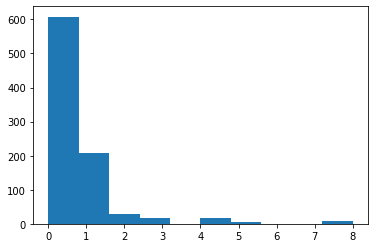

In [6]:
plt.hist(data["SibSp"])

- 2以上を一つにまとめる

In [7]:
data.loc[data["SibSp"] > 1.5, "SibSp"] = 3
test.loc[test["SibSp"] > 1.5, "SibSp"] = 3

# X, yに分ける

In [8]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Middle
0,1,0,3,"Braund, Mr. Owen Harris",Mr,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",Mr,35.0,0,0,373450,8.0500,NaN,S,Mr


In [9]:
X = data.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin", "Embarked", "Middle"], axis=1)
y = data["Survived"]
X_test = test.drop(["PassengerId", "Name", "Ticket", "Cabin", "Embarked", "Middle"], axis=1)

In [10]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,Mr,22.0,1,0,7.2500
1,1,female,38.0,1,0,71.2833
2,3,female,26.0,0,0,7.9250
3,1,female,35.0,1,0,53.1000
4,3,Mr,35.0,0,0,8.0500


# ワンホットエンコーディング

- Pclass, Middle, SibSp -> ワンホットエンコーディング

In [11]:
X = pd.get_dummies(X, columns=["Pclass"])
X = pd.get_dummies(X, columns=["Sex"])
X = pd.get_dummies(X, columns=["SibSp"])
X_test = pd.get_dummies(X_test, columns=["Pclass"])
X_test = pd.get_dummies(X_test, columns=["Sex"])
X_test = pd.get_dummies(X_test, columns=["SibSp"])

In [12]:
X.head()

,Age,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_Mr,Sex_female,Sex_notMr,SibSp_0,SibSp_1,SibSp_3
0,22.0,0,7.2500,0,0,1,1,0,0,0,1,0
1,38.0,0,71.2833,1,0,0,0,1,0,0,1,0
2,26.0,0,7.9250,0,0,1,0,1,0,1,0,0
3,35.0,0,53.1000,1,0,0,0,1,0,0,1,0
4,35.0,0,8.0500,0,0,1,1,0,0,1,0,0


# 標準化

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
std = StandardScaler()
X_std = std.fit_transform(X)
X_test_std = std.fit_transform(X_test)

In [15]:
pd.DataFrame(X_std).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.557497,-0.473674,-0.502445,-0.565685,-0.510152,0.902587,0.850532,-0.737695,-0.268705,-1.465746,1.806421,-0.300957
1,0.648492,-0.473674,0.786845,1.767767,-0.510152,-1.107926,-1.175735,1.355574,-0.268705,-1.465746,1.806421,-0.300957
2,-0.255999,-0.473674,-0.488854,-0.565685,-0.510152,0.902587,-1.175735,1.355574,-0.268705,0.682247,-0.553581,-0.300957
3,0.422369,-0.473674,0.420730,1.767767,-0.510152,-1.107926,-1.175735,1.355574,-0.268705,-1.465746,1.806421,-0.300957
4,0.422369,-0.473674,-0.486337,-0.565685,-0.510152,0.902587,0.850532,-0.737695,-0.268705,0.682247,-0.553581,-0.300957


# 正規化

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
norm = MinMaxScaler()
X_norm = norm.fit_transform(X)
X_test_norm = norm.fit_transform(X_test)

In [18]:
pd.DataFrame(X_norm).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.271174,0.0,0.014151,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.472229,0.0,0.139136,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.321438,0.0,0.015469,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.434531,0.0,0.103644,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.434531,0.0,0.015713,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


### 4-fold cross validation, Grid Search

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# RandomForest

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
def param():
  ret = {
      "n_estimators":[100, 200, 300],
      "max_features": [3, 5, 7, 10],
      "min_samples_split": [2, 10, 20],
  }
  return ret
gscv = GridSearchCV(RandomForestClassifier(random_state=0), param(), cv=4)
gscv.fit(X_std, y)

print('Best score: {}'.format(gscv.best_score_))
print('Best parameters: {}'.format(gscv.best_params_))

Best score: 0.8338945005611672
Best parameters: {'max_features': 7, 'min_samples_split': 10, 'n_estimators': 200}


In [22]:
rf = RandomForestClassifier(max_features=10, min_samples_split=10, n_estimators=200)
scores = cross_val_score(rf, X_std, y, cv=4)
print("Cross-Validation scores: {}".format(scores))
print("Average score: {}".format(np.mean(scores)))

Cross-Validation scores: [0.81696429 0.86098655 0.83783784 0.82432432]
Average score: 0.8350282487404124


# LogisticRegression

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
def param():
  ret = {
      'C':[0.001, 0.01, 0.1, 1, 10, 100],
  }
  return ret
gscv = GridSearchCV(LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000), param(), cv=4)
gscv.fit(X_std, y)

print('Best score: {}'.format(gscv.best_score_))
print('Best parameters: {}'.format(gscv.best_params_))

Best score: 0.8114478114478114
Best parameters: {'C': 0.01}


In [25]:
lr = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000, C=0.1)
scores = cross_val_score(lr, X_std, y, cv=4)
print("Cross-Validation scores: {}".format(scores))
print("Average score: {}".format(np.mean(scores)))

Cross-Validation scores: [0.80357143 0.84304933 0.78378378 0.7972973 ]
Average score: 0.8069254592516925


# SVM

In [26]:
from sklearn.svm import SVC

In [27]:
def param():
  ret = {
      'C':[0.001, 0.01, 0.1, 1, 10, 100],
      'gamma':[0.001, 0.01, 0.1, 1, 10, 100]
  }
  return ret
gscv = GridSearchCV(SVC(), param(), cv=4)
gscv.fit(X_std, y)

print('Best score: {}'.format(gscv.best_score_))
print('Best parameters: {}'.format(gscv.best_params_))

Best score: 0.8260381593714927
Best parameters: {'C': 10, 'gamma': 0.01}


In [28]:
svm = SVC(C=1, gamma=0.1)
scores = cross_val_score(svm, X_std, y, cv=4)
print("Cross-Validation scores: {}".format(scores))
print("Average score: {}".format(np.mean(scores)))

Cross-Validation scores: [0.79910714 0.82959641 0.7972973  0.83783784]
Average score: 0.8159596726370829


# Decision Tree

In [29]:
from sklearn.tree import DecisionTreeClassifier

In [30]:
def param():
  ret = {
      "max_depth": [2,4,6,8,10],
      "max_features": ['log2', 'sqrt','auto'],
      "min_samples_split": [3, 5, 7, 9],
      "min_samples_leaf": [1,5,8],
      "criterion": ["gini", "entropy"],
  }
  return ret
gscv = GridSearchCV(DecisionTreeClassifier(random_state=0), param(), cv=4)
gscv.fit(X_std, y)

print('Best score: {}'.format(gscv.best_score_))
print('Best parameters: {}'.format(gscv.best_params_))

Best score: 0.8114478114478114
Best parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 9}


In [31]:
dt = DecisionTreeClassifier(criterion="gini", max_depth=6, max_features="log2", min_samples_split=7)
scores = cross_val_score(dt, X_std, y, cv=4)
print("Cross-Validation scores: {}".format(scores))
print("Average score: {}".format(np.mean(scores)))

Cross-Validation scores: [0.74553571 0.78923767 0.77927928 0.81081081]
Average score: 0.7812158681343099


# MLP

In [32]:
from sklearn.neural_network import MLPClassifier

In [33]:
def param():
  ret = {
      "hidden_layer_sizes": [(200,), (300,), (400,), (500,)],
      "batch_size": [20, 50, 100, 200],
      "activation": ["logistic", "tanh", "relu"]
  }
  return ret
gscv = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, random_state=0), param(), cv=4)
gscv.fit(X_norm, y)

print('Best score: {}'.format(gscv.best_score_))
print('Best parameters: {}'.format(gscv.best_params_))

/Users/y_imagawa/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best score: 0.8103254769921436
Best parameters: {'activation': 'relu', 'batch_size': 100, 'hidden_layer_sizes': (400,)}


In [34]:
def param():
  ret = {
      "hidden_layer_sizes": [(200,), (300,), (400,), (500,)],
      "batch_size": [20, 50, 100, 200],
      "activation": ["logistic", "tanh", "relu"]
  }
  return ret
gscv = GridSearchCV(MLPClassifier(max_iter=1000, early_stopping=True, random_state=0), param(), cv=4)
gscv.fit(X_std, y)

print('Best score: {}'.format(gscv.best_score_))
print('Best parameters: {}'.format(gscv.best_params_))

Best score: 0.8181818181818182
Best parameters: {'activation': 'relu', 'batch_size': 20, 'hidden_layer_sizes': (200,)}


In [35]:
mlp = MLPClassifier(activation="relu", batch_size=20, hidden_layer_sizes=(200,), max_iter=1000, early_stopping=True)
scores = cross_val_score(dt, X_std, y, cv=4)
print("Cross-Validation scores: {}".format(scores))
print("Average score: {}".format(np.mean(scores)))

Cross-Validation scores: [0.80357143 0.78026906 0.78378378 0.77027027]
Average score: 0.7844736352303616


# アンサンブル学習(Voting)

In [36]:
from sklearn.ensemble import VotingClassifier

In [41]:
vote_clf =  VotingClassifier([('lr', lr), ('svm', svm), ('dt', dt), ('mlp', mlp), ('rf', rf)], weights=[1, 1, 1, 1, 3])
scores = cross_val_score(vote_clf, X_std, y, cv=4)
print("Cross-Validation scores: {}".format(scores))
print("Average score: {}".format(np.mean(scores)))

Cross-Validation scores: [0.79910714 0.82959641 0.7972973  0.82432432]
Average score: 0.8125812942587045


In [42]:
vote_clf.fit(X_std, y)
print()

# 提出用ファイルを作成

In [43]:
pred = vote_clf.predict(X_test_std)
submit = pd.DataFrame({"PassengerId":test["PassengerId"], "Survived":pred})
submit.to_csv("gender_submission.csv",index=False)

# 結果

78くらい(下がった)

# 重要度をみてみる

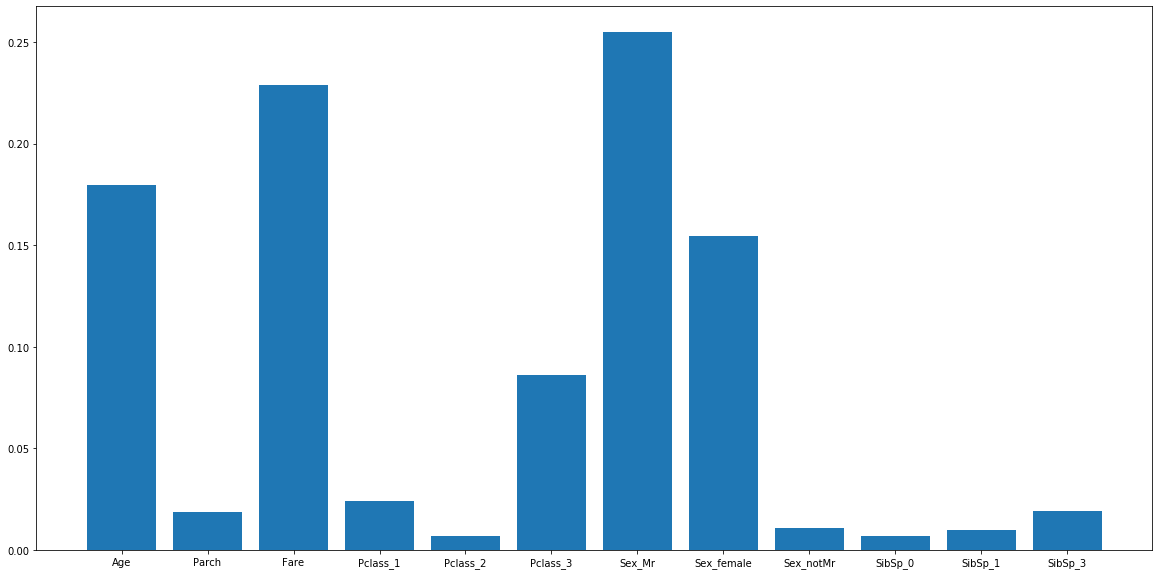

In [44]:
rf.fit(X_std, y)
feature = rf.feature_importances_
plt.figure(figsize=(20, 10))
plt.bar(range(len(feature)), feature, tick_label=X.columns)
plt.show()